In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
# from torchinfo import summary
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


In [24]:
from lab1_utils import train_loop_sched, count_trainable_parameters, save_to_json
from lab1_utils import train, test
from lab1_utils import train, test, get_lr
from lab1_utils import multiple_diagnostic, test_class, simple_diagnostic

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# batch_size = 64
batch_size = 128
max_epochs = 30

opt_dict = dict(lr=0.001, momentum=0.9, nesterov=True, weight_decay=5e-4)

criterion = nn.CrossEntropyLoss()

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # some augmentation
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    # transforms.Resize(224)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    # transforms.Resize(224)
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

# create a split for train/validation. We can use early stop
trainset, valset = torch.utils.data.random_split(dataset, [40000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2,
                                          drop_last=True, pin_memory=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2,
                                        drop_last=False, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2,
                                         drop_last=False, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


# `ResNet18` training

In [5]:
loss_acc_dict = {}

In [42]:
resnet18 = models.resnet18(weights="DEFAULT")

resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)
resnet18 = resnet18.to(device)

optimizer = optim.SGD(resnet18.parameters(), **opt_dict)

# print(summary(resnet18))
print(f"Trainable parameters: {count_trainable_parameters(resnet18)}")

Trainable parameters: 11181642


In [28]:
losses_train, accs_train = [], []
losses_val, accs_val = [], []

In [ ]:
best_acc = 0.  # validation set best accuracy
model_state_dict = None  # model weights

In [29]:
_start = time.time()
_epoch_time = time.time()

# epoch number only for logging
for epoch in range(1, 5 + 1):
    ## Training
    loss_train, acc_train = train(resnet18, device, trainloader, criterion, optimizer)

    print(f"Epoch: {epoch}, Learning rate: {get_lr(optimizer):.6f}")
    print(f"Training - Loss: {loss_train:.4f}, Accuracy: {acc_train:.3f}, Runtime: {(time.time() - _epoch_time):.2f}")

    losses_train.append(loss_train)
    accs_train.append(acc_train)

    # Learning rate scheduler
    # if scheduler is not None:
        # scheduler.step()
    
    ## Validation
    loss_val, acc_val = test(resnet18, device, criterion, valloader)

    losses_val.append(loss_val)
    accs_val.append(acc_val)

    print(f"Validation - Loss: {loss_val:.4f}, Accuracy: {acc_val:.3f}")

    if acc_val > best_acc:
        print(f"Updated best accuracy at epoch {epoch}")
        best_acc = acc_val
        model_state_dict = resnet18.state_dict()
    print(f"Best validation accuracy: {best_acc:.3f}")

    _epoch_time = time.time()
    print("=======")

_end = time.time()
print(f"Done! - Runtime: {(_end-_start):.2f} seconds")

Epoch: 1, Learning rate: 0.001000
Training - Loss: 0.5627, Accuracy: 0.802, Runtime: 13.98
Validation - Loss: 0.6238, Accuracy: 0.783
Updated best accuracy at epoch 1
Best validation accuracy: 0.783
Epoch: 2, Learning rate: 0.001000
Training - Loss: 0.5313, Accuracy: 0.811, Runtime: 14.06
Validation - Loss: 0.6358, Accuracy: 0.784
Updated best accuracy at epoch 2
Best validation accuracy: 0.784
Epoch: 3, Learning rate: 0.001000
Training - Loss: 0.5110, Accuracy: 0.819, Runtime: 13.70
Validation - Loss: 0.6075, Accuracy: 0.792
Updated best accuracy at epoch 3
Best validation accuracy: 0.792
Epoch: 4, Learning rate: 0.001000
Training - Loss: 0.4869, Accuracy: 0.828, Runtime: 14.02
Validation - Loss: 0.6018, Accuracy: 0.799
Updated best accuracy at epoch 4
Best validation accuracy: 0.799
Epoch: 5, Learning rate: 0.001000
Training - Loss: 0.4651, Accuracy: 0.837, Runtime: 13.93
Validation - Loss: 0.5915, Accuracy: 0.799
Updated best accuracy at epoch 5
Best validation accuracy: 0.799
Done!

In [37]:
resnet18_best = models.resnet18()
resnet18_best.fc = nn.Linear(resnet18_best.fc.in_features, 10)

resnet18_best.load_state_dict(model_state_dict)

resnet18_best = resnet18_best.to(device)

In [43]:
loss_test, acc_test = test(resnet18, device, criterion, testloader)
print(f"Test loss: {loss_test:.4f}, test accuracy {acc_test:.3f}")

loss_test, acc_test = test(resnet18_best, device, criterion, testloader)
print(f"Test loss: {loss_test:.4f}, test accuracy {acc_test:.3f}")

Test loss: 2.4387, test accuracy 0.086
Test loss: 0.5716, test accuracy 0.808


In [20]:
test_class(resnet18, device, criterion, testloader, classes)

Final loss: 0.6163, Accuracy: 0.788
-------
Accuracy for class: plane is 85.2 %
Accuracy for class: car   is 85.8 %
Accuracy for class: bird  is 68.0 %
Accuracy for class: cat   is 60.2 %
Accuracy for class: deer  is 79.3 %
Accuracy for class: dog   is 70.2 %
Accuracy for class: frog  is 86.2 %
Accuracy for class: horse is 80.8 %
Accuracy for class: ship  is 87.1 %
Accuracy for class: truck is 88.0 %


In [17]:
def early_stopping_diagnostic(accs_train, accs_val, fig_title=""):
    # accs_train, accs_val of type list
    max_epochs = len(accs_train)
    epochs_seq = np.arange(1, max_epochs + 1)

    # plot only training loss and accuracy
    fig, ax = plt.subplots()
    # fig.suptitle("Training performance")
    fig.suptitle(fig_title)

    ax.plot(epochs_seq, accs_train, label="Train")
    ax.plot(epochs_seq, accs_val, label="Val")
    ax.grid("both")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.tick_params(axis="y")
    ax.set_xticks(np.arange(1, max_epochs+1, step=4))
    ax.set_xticklabels(np.arange(1, max_epochs + 1, 4))
    ax.legend()

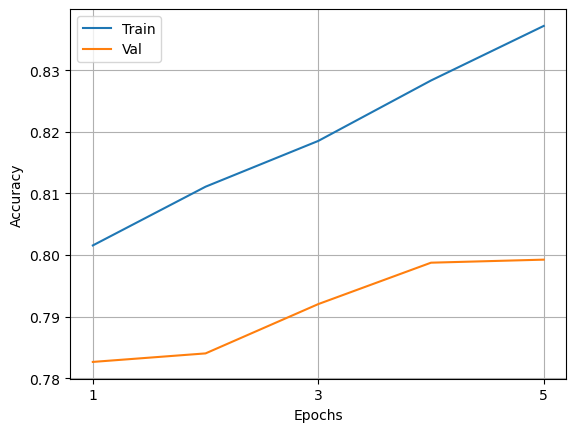

In [45]:
early_stopping_diagnostic(accs_train, accs_val)

In [46]:
from lab1_utils import save_to_json

seq_dict = {"ResNet18": [losses_train, accs_train, losses_val, accs_val]}
save_to_json(seq_dict, "resnet18_early_stopping.json")

# Final results

In [15]:
import json

with open('./plots/resnet18_early_stopping.json', 'r') as file:
    loaded_results = json.load(file)

In [21]:
print(f"Best epoch: {np.argmax(loaded_results['ResNet18'][3])}")

Best epoch: 41


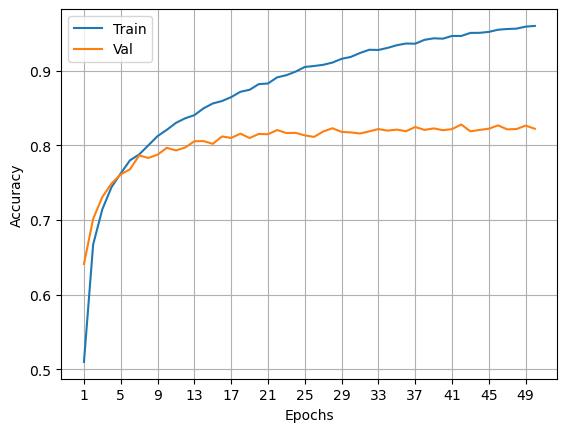

In [19]:
import numpy as np
import matplotlib.pyplot as plt
early_stopping_diagnostic(loaded_results['ResNet18'][1], loaded_results['ResNet18'][3])
plt.savefig("./plots/resnet-early_stopping.pdf")